In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from analyze import HistoryEntry

In [5]:
log_dir = 'docker_data/hc_profiler_sweep_correct1/cifar100+shufflenetv2+bs8+adam+lr0.001+tm0.5+me100+eta0.5+beta2.0+2022112711481669567728'
history_file = f'{log_dir}/history.py'

In [6]:
history = eval(open(history_file).read())

In [7]:
def convert_HistoryEntry_to_dict(h_entry):
    dict = {
        'batch_size': h_entry.bs, 
        'learning_rate': h_entry.lr,
        'power_limit': h_entry.pl, 
        'learning_rate_factor': h_entry.factor,
        'energy': h_entry.energy, 
        'time': h_entry.time, 
        'accuracy': h_entry.accuracy,
        'total_cost': h_entry.total_cost
    }
    return dict

In [8]:
history_list = [convert_HistoryEntry_to_dict(he) for he in history]

In [9]:
history_df = pd.DataFrame(history_list)
history_df.head()

,batch_size,learning_rate,power_limit,learning_rate_factor,energy,time,accuracy,total_cost
0,8,0.0008,175,0.8,97.069213,2.180381,0.0115,5.158387
1,8,0.0008,150,0.8,95.983149,2.242382,0.0101,6.016315
2,8,0.0008,125,0.8,96.967632,2.238270,0.0133,4.576969
3,8,0.0008,100,0.8,97.486305,2.191365,0.0102,5.854088
4,8,0.0010,175,1.0,97.340309,2.227548,0.0122,4.972549


In [19]:
# For each (bs, lr) pair, get power limit with min total_cost
# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby
MAXPOWER = 175
ETA = 0.5
history_df["alt_cost"] = (ETA * history_df.energy + (1 - ETA) * MAXPOWER) * history_df.time/history_df.accuracy
pl100 = history_df[history_df.power_limit == 150]
# cost_idx = history_df.groupby(['batch_size', 'learning_rate_factor'])['total_cost'].transform(min) == history_df['total_cost']
# history_df[cost_idx].head()

In [20]:
# cost_heatmap_df = history_df[cost_idx].pivot_table(index='batch_size', columns='learning_rate_factor', values='total_cost')
# cost_heatmap_df.head()

learning_rate_factor,0.8,1.0,1.2
batch_size,,,
8,4.576969,4.972549,4.275589
16,11.946407,11.625261,9.204961
32,19.390478,12.799200,16.191738
64,42.847574,60.039634,59.579729
128,116.399531,132.698545,150.260753


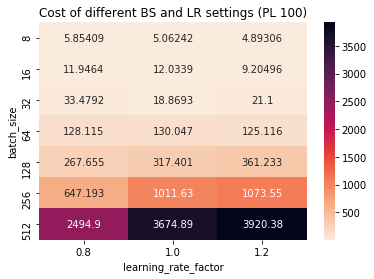

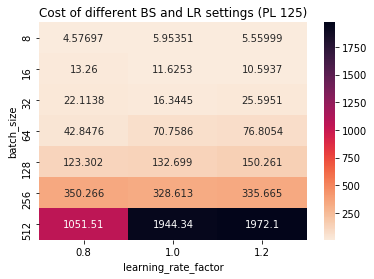

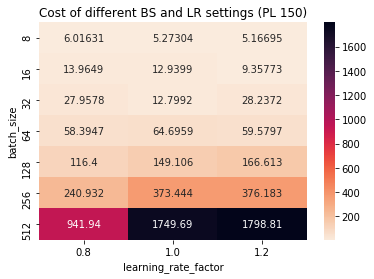

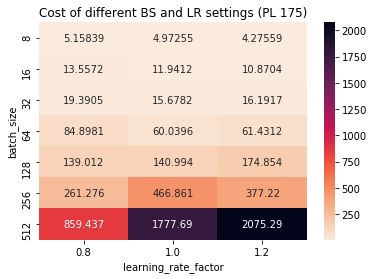

In [23]:
pls = [100, 125, 150, 175]
cmap = sns.cm.rocket_r
for i in range(len(pls)):
    sns.heatmap(history_df[history_df.power_limit == pls[i]].pivot("batch_size", "learning_rate_factor", "total_cost"), annot=True, fmt='g', cmap=cmap)
    plt.title(f'Cost of different BS and LR settings (PL {pls[i]})')
    plt.show()

In [22]:
factor_lr_mapping = history_df.pivot_table(index='batch_size', columns='learning_rate_factor', values='learning_rate')
factor_lr_mapping

learning_rate_factor,0.8,1.0,1.2
batch_size,,,
8,0.000800,0.001000,0.001200
16,0.001131,0.001414,0.001697
32,0.001600,0.002000,0.002400
64,0.002263,0.002828,0.003394
128,0.003200,0.004000,0.004800
256,0.004525,0.005657,0.006788
512,0.006400,0.008000,0.009600


# Is it the same with power?

In [24]:
history_df['avg_power'] = history_df['energy'] / history_df['time']
history_df.head()

,batch_size,learning_rate,power_limit,learning_rate_factor,energy,time,accuracy,total_cost,alt_cost,avg_power
0,8,0.0008,175,0.8,97.069213,2.180381,0.0115,5.158387,25791.934811,44.519384
1,8,0.0008,150,0.8,95.983149,2.242382,0.0101,6.016315,30081.574987,42.804097
2,8,0.0008,125,0.8,96.967632,2.238270,0.0133,4.576969,22884.844862,43.322589
3,8,0.0008,100,0.8,97.486305,2.191365,0.0102,5.854088,29270.437643,44.486568
4,8,0.0010,175,1.0,97.340309,2.227548,0.0122,4.972549,24862.747106,43.698417


In [27]:
# A bit weird, but we'll pick the (bs, lr) pair with the lowest average power... 
# Note that "energy" is average power
power_idx = history_df.groupby(['batch_size', 'learning_rate_factor'])['energy'].transform(min) == history_df['energy']
history_df[power_idx].head()

,batch_size,learning_rate,power_limit,learning_rate_factor,energy,time,accuracy,total_cost,alt_cost,avg_power
1,8,0.000800,150,0.8,95.983149,2.242382,0.0101,6.016315,30081.574987,42.804097
5,8,0.001000,150,1.0,95.124534,2.283929,0.0117,5.273037,26365.184704,41.649510
11,8,0.001200,100,1.2,95.781154,2.240702,0.0124,4.893063,24465.315804,42.746051
15,16,0.001131,100,0.8,98.790221,2.748906,0.0126,11.946407,29866.018367,35.938010
19,16,0.001414,100,1.0,98.709440,2.747872,0.0125,12.033898,30084.744470,35.922134


In [31]:
power_heatmap_df = history_df[power_idx].pivot_table(index='batch_size', columns='learning_rate_factor', values='energy')
power_heatmap_df.head()

learning_rate_factor,0.8,1.0,1.2
batch_size,,,
8,95.983149,95.124534,95.781154
16,98.790221,98.709440,98.986220
32,99.362580,98.868003,98.945550
64,99.055162,98.145763,98.549801
128,98.919035,99.025726,98.847101


Text(0.5, 1, 'Avg Power Usage for Different BS, LR')

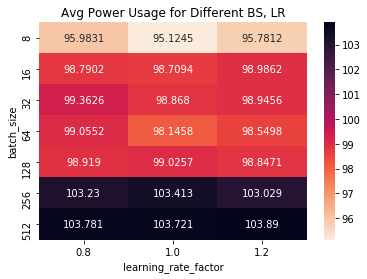

In [34]:
sns.heatmap(power_heatmap_df, annot=True, fmt='g', cmap=cmap)
plt.title("Avg Power Usage for Different BS, LR")

# How about accuracy?

In [13]:
history_df['acc_per_time'] = history_df['accuracy']
history_df.head()

,batch_size,learning_rate,power_limit,learning_rate_factor,energy,time,accuracy,total_cost,avg_power,acc_per_time
0,8,0.0008,175,0.8,97.069213,2.180381,0.011500,5.158387,44.519384,0.005274
1,8,0.0008,150,0.8,95.983149,2.242382,0.010100,6.016315,42.804097,0.004504
2,8,0.0008,125,0.8,96.967632,2.238270,0.013300,4.576969,43.322589,0.005942
3,8,0.0008,100,0.8,97.486305,2.191365,0.010200,5.854088,44.486568,0.004655
4,8,0.0010,175,1.0,97.340309,2.227548,0.012200,4.972549,43.698417,0.005477
...,...,...,...,...,...,...,...,...,...,...
79,512,0.0080,100,1.0,103.720980,52.088276,0.025195,3674.885674,1.991254,0.000484
80,512,0.0096,175,1.2,155.424793,18.080449,0.018359,2075.285654,8.596291,0.001015
81,512,0.0096,150,1.2,146.985970,18.734388,0.021387,1798.813922,7.845785,0.001142
82,512,0.0096,125,1.2,122.969401,21.383818,0.020605,1972.097416,5.750582,0.000964


In [16]:
# A bit weird, but we'll pick the (bs, lr) pair with the highest average accuracy rate...??? 
acc_idx = history_df.groupby(['batch_size', 'learning_rate_factor'])['acc_per_time'].transform(max) == history_df['acc_per_time']
history_df[acc_idx].head()

,batch_size,learning_rate,power_limit,learning_rate_factor,energy,time,accuracy,total_cost,avg_power,acc_per_time
2,8,0.000800,125,0.8,96.967632,2.238270,0.0133,4.576969,43.322589,0.005942
4,8,0.001000,175,1.0,97.340309,2.227548,0.0122,4.972549,43.698417,0.005477
8,8,0.001200,175,1.2,97.414343,2.228714,0.0142,4.275589,43.708766,0.006371
15,16,0.001131,100,0.8,98.790221,2.748906,0.0126,11.946407,35.938010,0.004584
18,16,0.001414,125,1.0,114.343440,2.470951,0.0123,11.625261,46.275068,0.004978


In [17]:
acc_heatmap_df = history_df[acc_idx].pivot_table(index='batch_size', columns='learning_rate_factor', values='acc_per_time')
acc_heatmap_df.head()

learning_rate_factor,0.8,1.0,1.2
batch_size,,,
8,0.005942,0.005477,0.006371
16,0.004584,0.004978,0.006188
32,0.006278,0.009522,0.007532
64,0.005563,0.004203,0.004241
128,0.004384,0.003619,0.003172


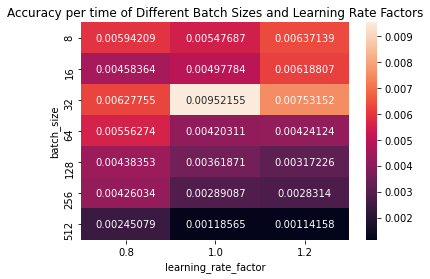

In [18]:
sns.heatmap(history_df[acc_idx].pivot_table(index='batch_size', columns='learning_rate_factor', values='acc_per_time'), annot=True, fmt='g')
plt.title('Accuracy per time of Different Batch Sizes and Learning Rate Factors')
plt.show()